In [49]:
from __future__ import absolute_import, division, print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(1234)

In [73]:
matplotlib.rcParams.update({'font.size': 16})

# Within-County Regression

In [118]:
data = pickle.load(open('data/processed_data/clean_regression_2017', 'rb'))
idxs = data[:, 0]
data = data[:, 1:]
data[:, 3] = data[:, 3] + data[:, 2]
data = data[:, 3:]
print(idxs.shape, data.shape)

(3093,) (3093, 4)


In [119]:
feature_to_name = {
    0: 'index',
    #1: '% less than HS diploma',
    #2: '% only HS diploma',
    #3: '% some college',
    1: '% some college or greater',
    2: 'population',
    3: '% in poverty',
    4: '% unemployed',
}

% some college or greater 51.71008729388942 10.638378042881463
% in poverty 15.390300678952473 6.245691926695084
% unemployed 4.556870352408665 1.5675094387631234


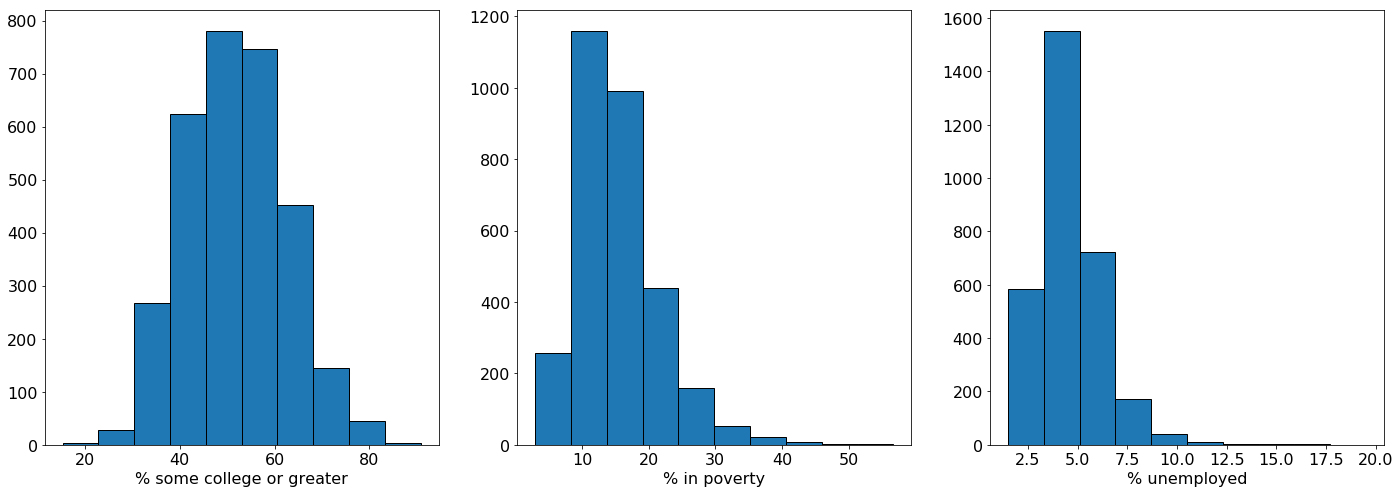

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
idx = 0
for i in [1, 3, 4]:
    print(feature_to_name[i], np.mean(data[:, i - 1]), np.std(data[:, i - 1]))
    axes[idx].hist(data[:, i - 1], edgecolor='black')
    axes[idx].set_xlabel(feature_to_name[i])
    idx += 1
plt.show()

In [123]:
def do_regression(data, num_folds=5, labels=None, seed=1234):
    if labels is None:
        labels = np.arange(data.shape[1])
        
    for label in labels:
        if feature_to_name[label + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        data_idxs = np.delete(np.arange(data.shape[1]), label)
        x = data[:, data_idxs]
        # This does z-score normalization of data
        x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        y = data[:, label]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(feature_to_name[label + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [124]:
do_regression(data)


=== % some college or greater ===
Mean Squared Error: mean = 71.42953510583877, median = 70.90388508031926, std = 8.910002168362329, min = 58.68196649225366, max = 85.69738365058515
Mean Absolute Error: mean = 6.549494566871806, median = 6.5425416640528065, std = 0.3100061945847617, min = 6.026671635954233, max = 6.910694394511221
Label stats: min = 15.3, max = 90.8, mean = 51.71008729388942, std = 10.638378042881463

=== % in poverty ===
Mean Squared Error: mean = 20.669302412904507, median = 20.739644272278923, std = 1.6022669630452953, min = 17.877650677496977, max = 22.69606586639621
Mean Absolute Error: mean = 3.3330070582886955, median = 3.306425732534178, std = 0.06059309867065745, min = 3.249294677643827, max = 3.4053375446233356
Label stats: min = 3.0, max = 56.7, mean = 15.390300678952473, std = 6.245691926695084

=== % unemployed ===
Mean Squared Error: mean = 1.6050542189134913, median = 1.4720478213663863, std = 0.28754233537609164, min = 1.2977195786269138, max = 2.12573

Note that I also tried Ridge and Lasso regression and neither improved performance. Our task isn't complex enough to require regularization.

In [203]:
def plot_concordance(data, labels=None, seed=1234):
    if labels is None:
        labels = np.arange(data.shape[1])
        
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    idx = 0
    for label in labels:
        if feature_to_name[label + 1] == 'population':
            continue
        
        kf = KFold(n_splits=2, shuffle=True, random_state=seed)
        data_idxs = np.delete(np.arange(data.shape[1]), label)
        x = data[:, data_idxs]
        # This does z-score normalization of data
        x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        y = data[:, label]
        
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            axes[0, idx].scatter(y_test, y_pred, s=20)
            axes[0, idx].plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), color='red')
            axes[0, idx].set_xlabel('True Value')
            axes[0, idx].set_ylabel('Predicted Value')
            axes[0, idx].set_title('Concordance for {}'.format(feature_to_name[label + 1]))
            
            im = axes[1, idx].matshow(model.coef_[np.newaxis, :], cmap='jet')
            plt.colorbar(im, ax=axes[1, idx], orientation='horizontal')
            axes[1, idx].set_yticks([], [])
            axes[1, idx].set_xticklabels([''] + [feature_to_name[i + 1] for i in data_idxs])
            
            idx += 1
            break
    plt.tight_layout()
    plt.show()

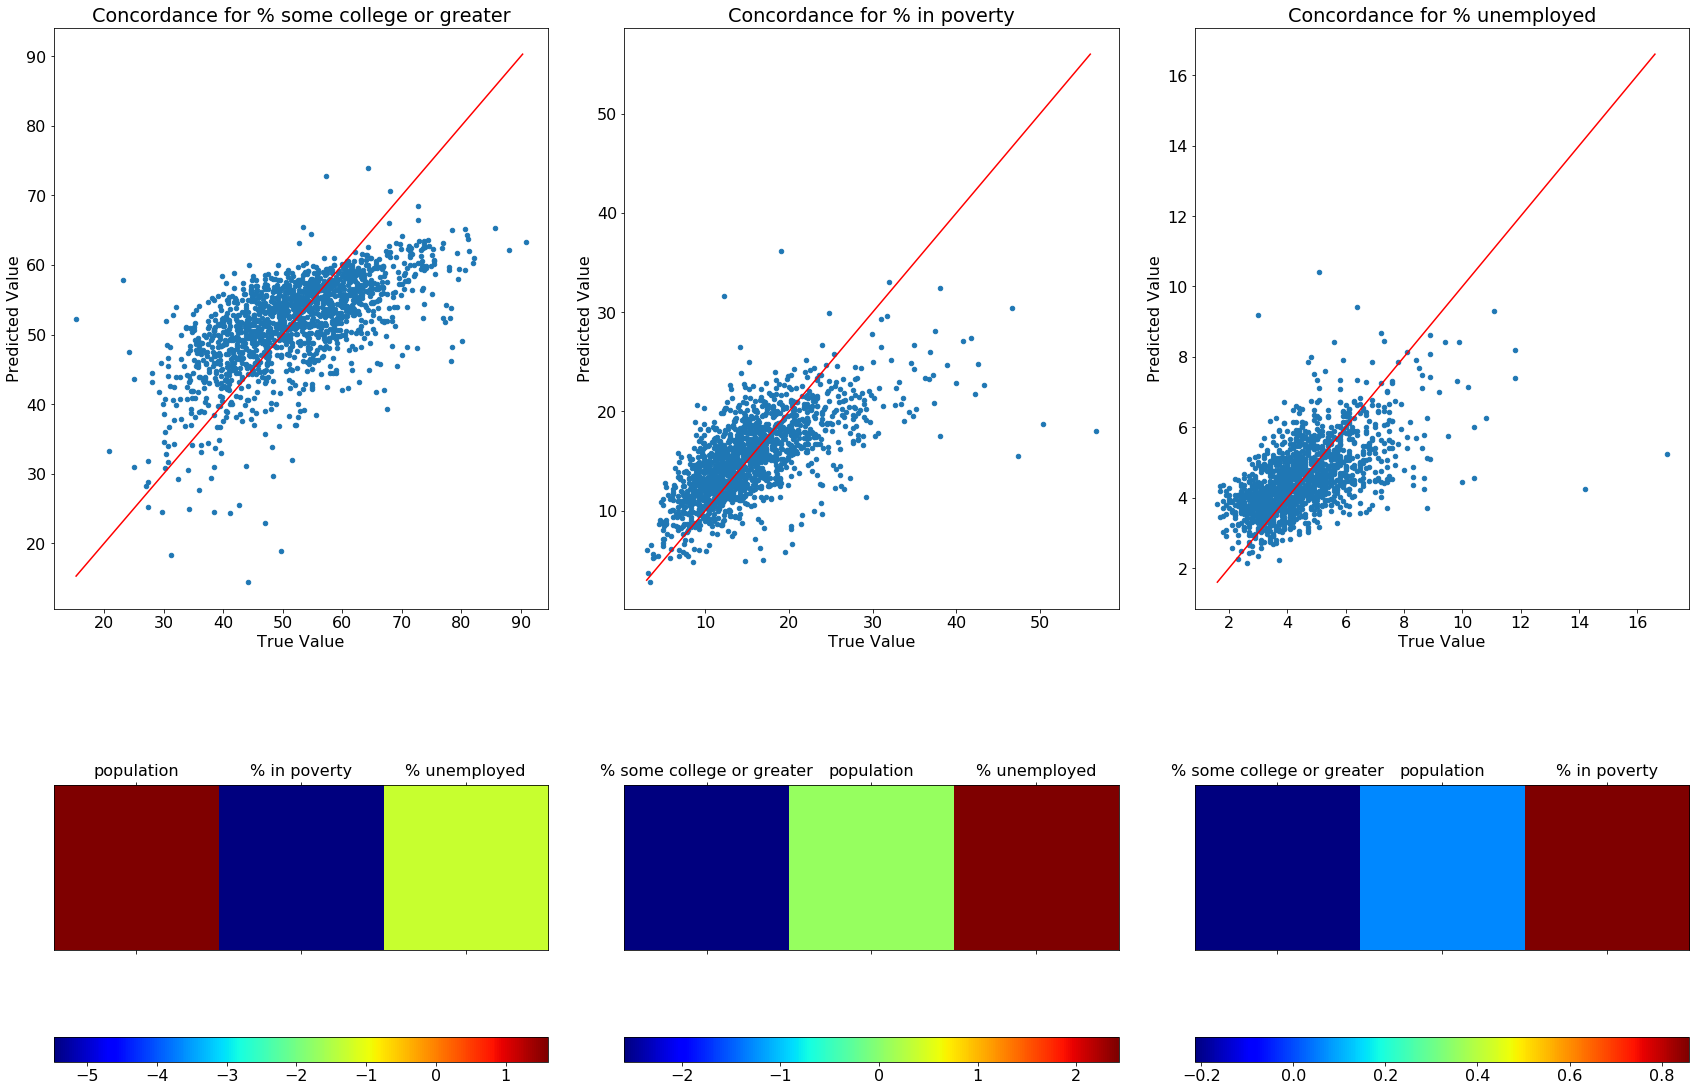

In [204]:
plot_concordance(data)